**Likelihood function:**
\begin{align*}
L_n(\theta) \equiv f(x_1, ..., x_n | \theta) = \prod_{i=1}^n f(x_i|\theta)
\end{align*}

**Loss Log Likelihood function:**
\begin{align*}
\ell_n(\theta) \equiv -\text{log}\;L_n(\theta) = -\sum_{i=1}^n \text{log}\; f(x_i|\theta)
\end{align*}

**MLE:**
\begin{align*}
\hat\theta = \underset{\theta}{\text{argmin}}\; \ell_n(\theta)
\end{align*}

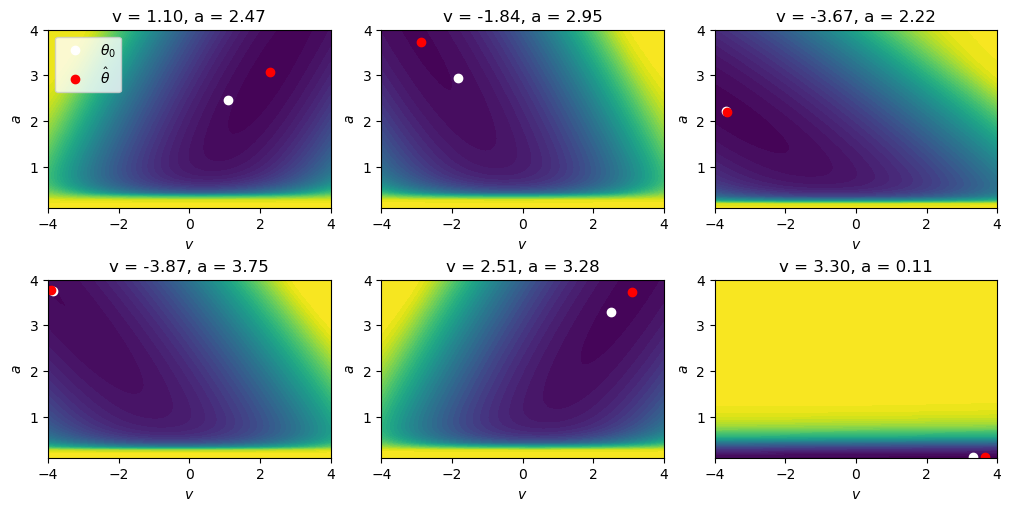

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyddm
from joblib import Parallel, delayed
from scipy.optimize import minimize


def loss_likelihood(x0, ddm, samples, epsilon=1e-10):
    """minimize negative log likelihood"""
    ddm.set_model_parameters(x0)
    solution = ddm.solve_analytical()

    loglikelihood = 0

    # upper (top) boundary
    top_idx = (samples.choice_upper / solution.dt).astype(int)  # map times to indices
    top_likelihoods = solution.pdf("_top")[top_idx]  # likelihoods for observed RTs
    loglikelihood += np.sum(np.log(top_likelihoods + epsilon))

    # lower (bottom) boundary
    bottom_idx = (samples.choice_lower / solution.dt).astype(int)  # map times to indices
    bottom_likelihoods = solution.pdf("_bottom")[bottom_idx]  # likelihoods for observed RTs
    loglikelihood += np.sum(np.log(bottom_likelihoods + epsilon))

    return -loglikelihood


# initialize ddm
n_samples = 1000
bounds = {"v": (-4, +4), "a": (0.1, 4)}
ddm = pyddm.gddm(drift="v", bound="a", noise=1.0, parameters=bounds, mixture_coef=0)

# parameter combinations to plot
rng = np.random.default_rng(0)
params_grid = np.column_stack((rng.uniform(*bounds["v"], 6), rng.uniform(*bounds["a"], 6)))

# parameter domain grid
v = np.linspace(*bounds["v"], 50)
a = np.linspace(*bounds["a"], 50)
v_grid, a_grid = np.meshgrid(v, a)

fig, axs = plt.subplots(2, 3, figsize=(10, 5), layout="constrained")

for ax, params in zip(axs.flatten(), params_grid):
    ddm.set_model_parameters(params)
    solution = ddm.solve_analytical()
    samples = solution.sample(k=n_samples, seed=0)
    params_ = minimize(loss_likelihood, x0=params, args=(ddm, samples), method="BFGS").x

    # loss_likelihood at each point on the grid
    loss_values = np.zeros(shape=(50, 50))
    for i in range(v_grid.shape[0]):
        for j in range(a_grid.shape[0]):
            loss_values[i, j] = loss_likelihood([v_grid[i, j], a_grid[i, j]], ddm, samples)

    # plot loss likelihood
    ax.contourf(v_grid, a_grid, loss_values, levels=50, cmap="viridis")
    ax.plot(*params, "wo", label=r"$\theta_0$")
    ax.plot(*params_, "ro", label=r"$\hat\theta$")
    ax.set_title(f"v = {params[0]:.2f}, a = {params[1]:.2f}")
    ax.set_xlabel(r"$v$")
    ax.set_ylabel(r"$a$")

axs[0, 0].legend()

**Expected Hessian (Def 10.7):**

\begin{align*}
\mathcal{H}_\theta=\frac{\partial^2}{\partial\theta\partial\theta^{\prime}}\ell(\theta_0)
\end{align*}


**CLT (Thm 10.9):**

When the model is correctly specified, as $n \to \infty$:
\begin{align*}
\sqrt{n}(\widehat{\theta}-\theta_0) \underset{d}{\to} \mathcal{N}(0,\mathcal{H}_\theta^{-1})
\end{align*}

where $\mathcal{H}_\theta^{-1}$ is the matrix inverse of the Fisher information.

**Sample Hessian Estimator (Sec 10.15):**

\begin{align*}
\widehat{\mathcal{H}_\theta} &= \frac{1}{n}\frac{\partial^{2}}{\partial\theta\partial\theta^{\prime}}\ell_{n}(\widehat{\theta})\\
\widehat{V} &= \widehat{\mathcal{H}_\theta}^{-1}
\end{align*}

where $\widehat{V}$ is an estimator for the asymptotic covariance matrix. Standard errors are constructed by taking the square roots of the diagonal elements of $n^{-1} \widehat{V}$.


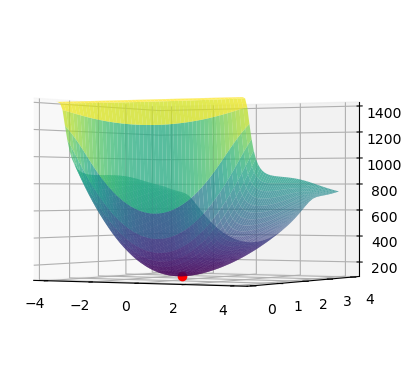

In [2]:
params = [0, 3]
ddm.set_model_parameters(params)
solution = ddm.solve_analytical()
samples = solution.sample(k=n_samples, seed=2)
fit = minimize(loss_likelihood, args=(ddm, samples), x0=params, method="BFGS")
params_ = fit.x

# loss_likelihood at each point on the grid
loss_values = np.zeros(shape=(50, 50))
for i in range(v_grid.shape[0]):
    for j in range(a_grid.shape[0]):
        loss_values[i, j] = loss_likelihood([v_grid[i, j], a_grid[i, j]], ddm, samples)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(v_grid, a_grid, loss_values, alpha=0.75, cmap="viridis")
ax.plot(*params, loss_likelihood(params, ddm, samples), "wo")
ax.plot(*params_, loss_likelihood(params_, ddm, samples), "ro")
ax.view_init(elev=0)

Text(0.5, 0, '$\\widehat\\text{se}(\\hat a)$')

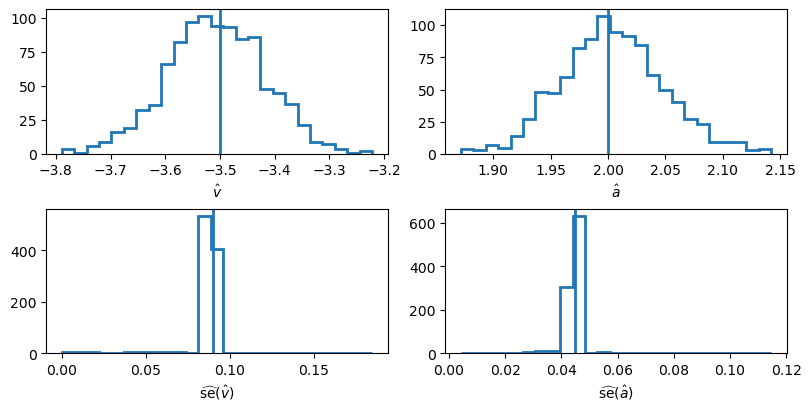

In [3]:
n_repeats = 1000
params = [-3.5, 2]
ddm.set_model_parameters(params)
solution = ddm.solve_analytical()


@delayed
def run_simulation(repeat):
    samples = solution.sample(k=n_samples, seed=repeat + 2)
    fit = minimize(loss_likelihood, args=(ddm, samples), x0=[1, 1], method="BFGS")
    return fit.x, np.sqrt(np.diag(fit.hess_inv))


with Parallel(n_jobs=-2) as parallel:
    sim_results = np.asarray(parallel(run_simulation(repeat) for repeat in range(n_repeats)))


# plot results
fig, axs = plt.subplots(2, 2, figsize=(8, 4), layout="constrained")
axs = axs.flatten()
hist_kwargs = dict(bins=25, histtype="step", lw=2)
vline_kwargs = dict(lw=2)

axs[0].hist(sim_results[:, 0, 0], **hist_kwargs)
axs[0].axvline(params[0], **vline_kwargs)
axs[0].set_xlabel(r"$\hat v$")

axs[1].hist(sim_results[:, 0, 1], **hist_kwargs)
axs[1].axvline(params[1], **vline_kwargs)
axs[1].set_xlabel(r"$\hat a$")

axs[2].hist(sim_results[:, 1, 0], **hist_kwargs)
axs[2].axvline(np.std(sim_results[:, 0, 0]), **vline_kwargs)
axs[2].set_xlabel(r"$\widehat\text{se}(\hat v)$")

axs[3].hist(sim_results[:, 1, 1], **hist_kwargs)
axs[3].axvline(np.std(sim_results[:, 0, 1]), **vline_kwargs)
axs[3].set_xlabel(r"$\widehat\text{se}(\hat a)$")